In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import seaborn as sns

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

from scripts.auxiliar import get_files_in_directory, spherical2cartesian

In [2]:
current_path = os.getcwd() 
data_path = current_path + '/data'
data_path_PP = data_path + "/poles_NAM"
file_name = "/NAM_poles_0_130.xlsx"

In [3]:
df_NAM = pd.read_excel(data_path_PP + file_name)

Calculate cartesian coordinates

In [4]:
df_NAM["x"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[0], axis=1)
df_NAM["y"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[1], axis=1)
df_NAM["z"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[2], axis=1)

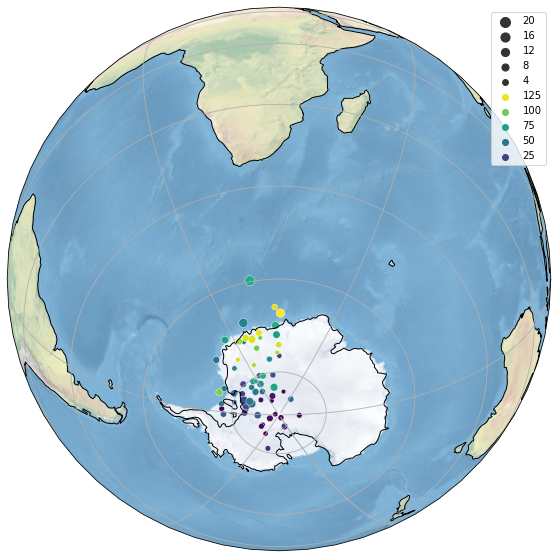

In [5]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -60)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = df_NAM['plon'], y = df_NAM['plat'],
                hue = df_NAM['age'],  size = (df_NAM['max_age'] - df_NAM['min_age']) , sizes=(20, 100),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

In [6]:
df_NAM.columns

Index(['pole_id', 'name', 'min_age', 'max_age', 'age', 'slat', 'slon', 'N',
       'k', 'alpha95', 'dp', 'dm', 'plat', 'plon', 'K', 'A95', 'plateID',
       'lithology', 'Rlat', 'Rlon', 'Euler_lat', 'Euler_lon', 'Euler_ang',
       'author', 'Q', 'reliability', 'age constraints', 'x', 'y', 'z'],
      dtype='object')

## Parametric bootstrap of paleomagnetic poles

In [7]:
pole_id, age_bst, vgp_lat_bst, vgp_lon_bst = [], [], [], []

for _,i in df_NAM.iterrows():
    
    #print(i.k, i.N, i.plon, i.plat)
    directions_temp = ipmag.fishrot(k = i.k, n = i.N, dec = i.plon, inc = i.plat, di_block = False)
    
    vgp_lon_bst.append(directions_temp[0])
    vgp_lat_bst.append(directions_temp[1])
    age_bst.append([np.random.randint(i.min_age,np.ceil(i.max_age)) for _ in range(i.N)])
    pole_id.append([i.name for _ in range(i.N)])

vgp_lon_bst = [item for sublist in vgp_lon_bst for item in sublist]
vgp_lat_bst = [item for sublist in vgp_lat_bst for item in sublist] 
age_bst = [item for sublist in age_bst for item in sublist]
pole_id = [item for sublist in pole_id for item in sublist]

dictionary = {
              'pole_id': pole_id,
              'plat': vgp_lat_bst,    
              'plon': vgp_lon_bst,
              'age': age_bst
              }

pseudo_vgps = pd.DataFrame(dictionary)

pseudo_vgps
#directions = ipmag.fishrot(k=kappa, n=N, dec=DI[0], inc=DI[1], di_block=True)

,pole_id,plat,plon,age
0,0,-75.198178,354.028914,0
1,0,-62.455397,10.106864,0
2,0,-77.136466,36.872713,0
3,0,-78.112148,300.854118,0
4,0,-60.613535,13.855605,0
...,...,...,...,...
1777,64,-65.295824,39.675354,130
1778,64,-57.715839,34.062333,134
1779,64,-63.641775,38.899069,125
1780,64,-65.477509,41.389331,133


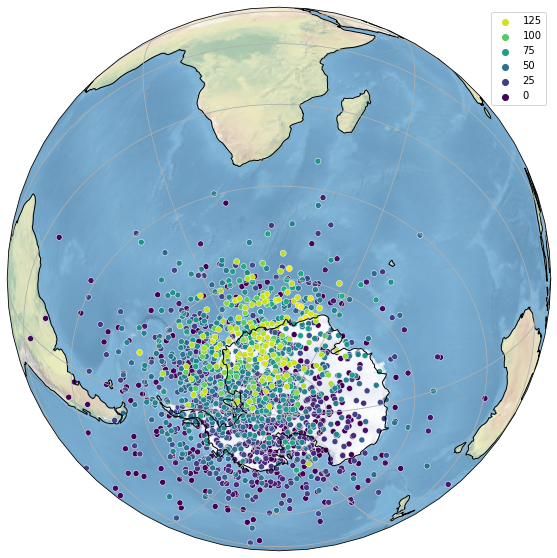

In [8]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -60)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = pseudo_vgps['plon'], y = pseudo_vgps['plat'],
                hue = pseudo_vgps['age'],  #size = (df_NAM['max_age'] - df_NAM['min_age']) , sizes=(20, 100),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

### Densities

<AxesSubplot:xlabel='age', ylabel='Count'>

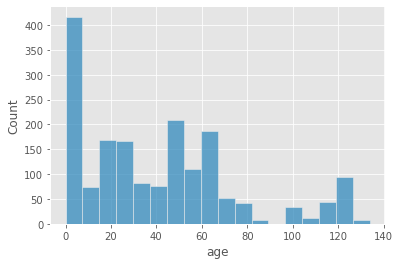

In [9]:
plt.style.use('ggplot')
sns.histplot(pseudo_vgps['age'])

In [10]:
def running_mean_APWP(data, window_length, spacing, max_age,min_age, fig_name=None):
    
    mean_pole_ages = np.arange(min_age,max_age+spacing,spacing)
    running_means = pd.DataFrame(columns=['age','N','alpha95','plon','plat'])
    
    for age in mean_pole_ages:
        window_min = age - (window_length/2)
        window_max = age + (window_length/2)
        poles = data.loc[(data['age'] >= window_min) & (data['age'] <= window_max)]
        mean = ipmag.fisher_mean(dec=poles['plon'].tolist(),inc=poles['plat'].tolist())
        running_means.loc[age] = [age,mean['n'],mean['alpha95'],mean['dec'],mean['inc']]
        
    return running_means

In [11]:
window_length = 20
spacing = 10
max_age = 110
min_age = 0

#NA_RM_20_10 = running_mean_APWP(pseudo_vgps,20,10,110,0)

running_mean_bst_20_10 = running_mean_APWP(pseudo_vgps,window_length, spacing, max_age,min_age)

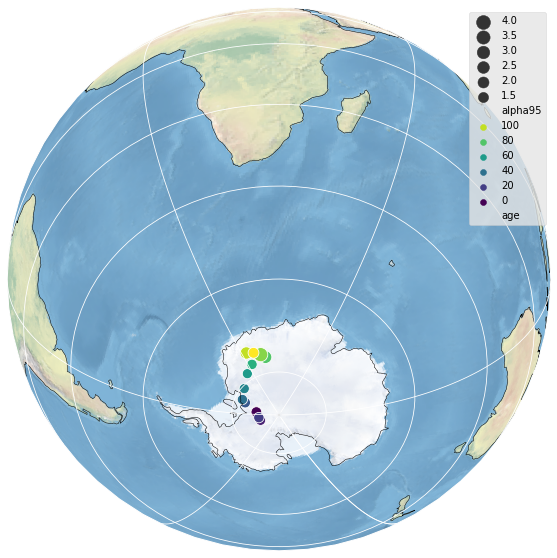

In [12]:
window_length = 20
spacing = 10
max_age = 110
min_age = 0
running_mean_bst_20_10 = running_mean_APWP(pseudo_vgps,window_length, spacing, max_age,min_age)

fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -60)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = running_mean_bst_20_10['plon'], y = running_mean_bst_20_10['plat'],
                hue = running_mean_bst_20_10['age'],  size = (running_mean_bst_20_10['alpha95']) , sizes=(100,200),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

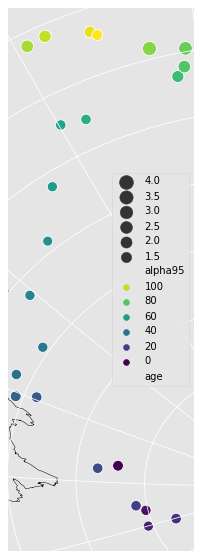

In [18]:
window_length = 20
spacing = 5
max_age = 110
min_age = 0
running_mean_bst_20_10 = running_mean_APWP(pseudo_vgps,window_length, spacing, max_age,min_age)

fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -60)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
#ax.stock_img()
ax.gridlines()

sns.scatterplot(x = running_mean_bst_20_10['plon'], y = running_mean_bst_20_10['plat'],
                hue = running_mean_bst_20_10['age'],  size = (running_mean_bst_20_10['alpha95']) , sizes=(100,200),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

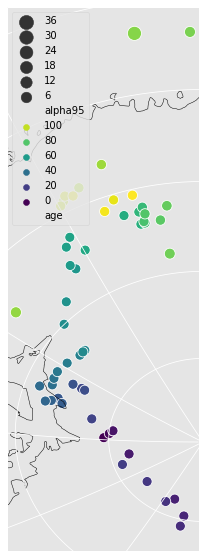

In [23]:
window_length = 12
spacing = 2
max_age = 110
min_age = 0
running_mean_bst_20_10 = running_mean_APWP(pseudo_vgps,window_length, spacing, max_age,min_age)

fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -60)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
#ax.stock_img()
ax.gridlines()

sns.scatterplot(x = running_mean_bst_20_10['plon'], y = running_mean_bst_20_10['plat'],
                hue = running_mean_bst_20_10['age'],  size = (running_mean_bst_20_10['alpha95']) , sizes=(100,200),
                palette="viridis",
                transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()